In [25]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import numpy as np
import random
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.regularizers import l2,l1
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
# Define hyperparameters
filters = 32
kernel_size = 3
dropout = 0.5
l2_lambda = 0.02
initial_learning_rate = 0.005
# Define the input shape
input_shape = (32, 32, 3)

# Define hyperparameters
filters = 32
kernel_size = 3
dropout = 0.5
l2_lambda = 0.02
initial_learning_rate = 0.005
# Define the input shape
input_shape = (32, 32, 3)

# Define the model
inputs = Input(shape=input_shape)
x = Conv2D(filters=filters,kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu' ,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu' ,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=filters*5, kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(dropout)(x)



outputs = Dense(10, activation='softmax')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=150, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
early_stoppping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,verbose=1, restore_best_weights=True)
# Compile the model
model2.compile(optimizer=optimizer ,loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#help(Conv2D)
#help(tf)
#help(model.compile)

In [27]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_15 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_16 (Ba  (None, 16, 16, 64)        256 

## Loading the CIFAR10 dataset

In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1 #proportion of the training data that you want to allocate for validation
val_indices = int(len(x_train) * val_split) # to ensure that you have a whole number of samples for validation.
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]

x_val, y_val = x_train[:val_indices], y_train[:val_indices]


print(f"Training data samples: {len(new_x_train)}")

print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")


Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


## Normalization

In [29]:
# Normalization
new_x_train_nor = new_x_train/255
x_val_nor  = x_val/255
x_test_nor = x_test/255
print(x_train.shape)

(50000, 32, 32, 3)


## Label preparation

In [30]:
from keras.src.utils.np_utils import to_categorical
total_class = len(np.unique(new_y_train))

new_y_train_hot = to_categorical( new_y_train, total_class)

y_val_hot  = to_categorical( y_val, total_class)

y_test_hot = to_categorical( y_test, total_class)

new_y_train_hot = to_categorical(new_y_train, total_class): This line one-hot encodes the class labels in the training data (new_y_train). The to_categorical function takes two arguments:
new_y_train: The original class labels for the training data.
total_class: The total number of classes in the dataset,

In [31]:
indx = [i for i in range(0, len(new_x_train_nor))]
random.shuffle(indx)
#indx

In [32]:
new_y_train_hot_1 =  []
new_x_train_nor_1 = []

small_f = 40000 # allocated length of the dataset
for i in range(small_f):
  new_x_train_nor_1.append(new_x_train_nor[indx[i]] )
  new_y_train_hot_1.append(new_y_train_hot[indx[i]] )


new_y_train_hot_1 = np.array(new_y_train_hot_1)
new_x_train_nor_1 = np.array(new_x_train_nor_1)

(array([3990., 4067., 3965., 4023., 3969., 3985., 3997., 4028., 4004.,
        3972.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

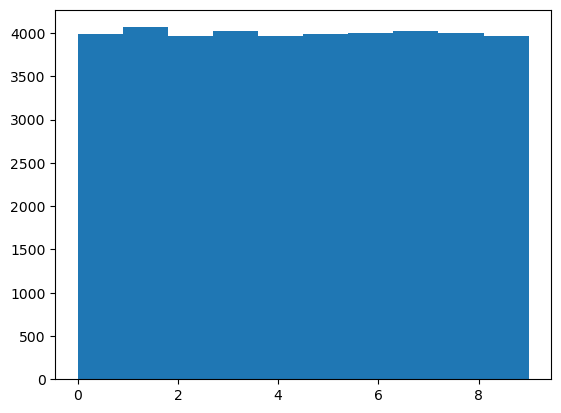

In [22]:
label_id = np.argmax(new_y_train_hot_1,-1)

plt.hist(label_id, 10)

## Augmented Dataet

In [33]:
batch_size = 32
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)



<code>auto = tf.data.AUTOTUNE:</code> This line uses TensorFlow's AUTOTUNE mechanism, which automatically determines the optimal number of elements to prefetch in order to maximize training speed. It's a good practice to use AUTOTUNE for prefetching to optimize data loading performance.<br>
<code>prefetch(auto)</code>Prefetching helps to overlap data loading and model training, improving overall training efficiency.

In [35]:



# Train the model using custom datasets
train_set = make_datasets(new_x_train_nor_1, new_y_train_hot_1)
val_set = make_datasets(x_val_nor, y_val_hot)
test_set = make_datasets(x_test_nor, y_test_hot)

# Train the model
history = model2.fit(train_set, epochs=100, validation_data=val_set,callbacks=[early_stoppping])
#history = model.fit(train_set, epochs=100, validation_data=val_set)
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/100
1250/1250 [==============================] - 183s 119ms/step - loss: 3.7504 - accuracy: 0.3407 - val_loss: 2.4825 - val_accuracy: 0.3230
Epoch 2/100
1250/1250 [==============================] - 144s 115ms/step - loss: 1.9884 - accuracy: 0.4976 - val_loss: 3.1102 - val_accuracy: 0.2304
Epoch 3/100
1250/1250 [==============================] - 151s 121ms/step - loss: 1.5455 - accuracy: 0.6180 - val_loss: 1.4361 - val_accuracy: 0.6426
Epoch 4/100
1250/1250 [==============================] - 156s 125ms/step - loss: 1.1955 - accuracy: 0.7043 - val_loss: 1.0990 - val_accuracy: 0.7298
Epoch 5/100
1250/1250 [==============================] - 148s 118ms/step - loss: 0.9360 - accuracy: 0.7756 - val_loss: 0.9641 - val_accuracy: 0.7542
Epoch 6/100
1250/1250 [==============================] - 141s 113ms/step - loss: 0.7589 - accuracy: 0.8277 - val_loss: 0.9218 - val_accuracy: 0.7702
Epoch 7/100
1250/1250 [==============================] - 144s 115ms/step - loss: 0.6570 - accuracy: 0.8624

  The Test accuracy is 69.85% for normal augmentation with overfitting. 

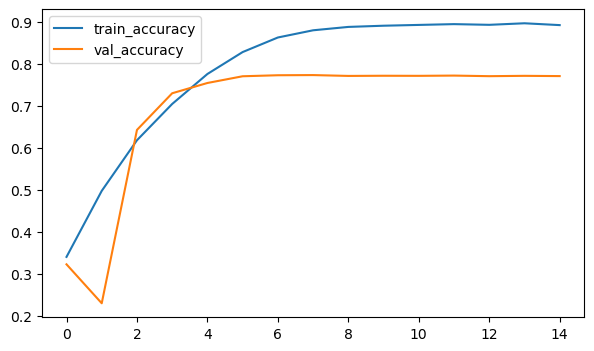

In [36]:
#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

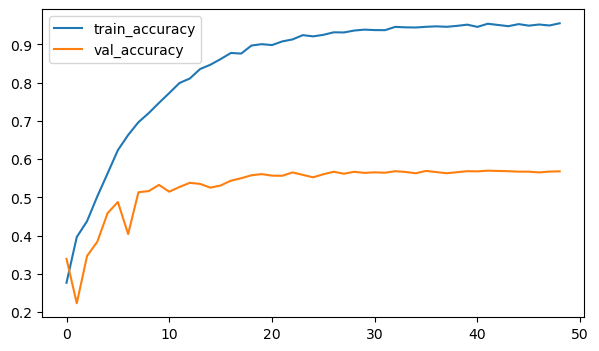

In [125]:
#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')


# Data Augmentation 
In here, I am exploring the role of data augmentation in image classification tasks. Data augmentation is a technique I am using to enhance the diversity of my training dataset by applying various transformations to the images.<p>

I have provided code that showcases the implementation of data augmentation in TensorFlow for image classification. The code defines two essential functions: make_datasets and make_augmented_datasets. The former is used for creating datasets for validation and testing, while the latter focuses on my training data. In the make_augmented_datasets function, I am incorporating data augmentation techniques such as random cropping, horizontal flipping, and brightness adjustment, which are crucial for improving my model's generalization. 

In [220]:
# Define hyperparameters
filters = 32
kernel_size = 3
dropout = 0.5
l2_lambda = 0.02
initial_learning_rate = 0.001
# Define the input shape
input_shape = (32, 32, 3)

# Define the model
inputs = Input(shape=input_shape)
x = Conv2D(filters=filters,kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(inputs)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = Dropout(.2)(x)
x = BatchNormalization()(x)

#x = MaxPooling2D()(x)

x = Conv2D(filters=filters*2.5, kernel_size=kernel_size, activation='relu' ,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(dropout)(x)


outputs = Dense(10, activation='softmax')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=150, decay_rate=0.9)
optimizer_ = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
early_stoppping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=7,verbose=1, restore_best_weights=True)
# Compile the model
model2.compile(optimizer=optimizer_ ,loss='categorical_crossentropy', metrics=['accuracy'])

In [219]:
batch_size = 32
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

def _augment_fn(images, labels):
    images = tf.image.random_crop(images, (32, 32, 3))
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_brightness(images, 0.9)
    return images, labels


def make_augmented_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(1024).map( _augment_fn, num_parallel_calls=auto)

    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(batch_size)


    return dataset.prefetch(auto)



train_set =   make_augmented_datasets(new_x_train_nor_1, new_y_train_hot_1) # only on train set
val_set =   make_datasets(x_val_nor, y_val_hot)
test_set =  make_datasets(x_test_nor, y_test_hot )


In [221]:
history = model2.fit(train_set, epochs=100, validation_data=val_set,callbacks=[early_stoppping])
#history = model.fit(train_set, epochs=100, validation_data=val_set)
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/100
313/313 [==============================] - 95s 263ms/step - loss: 9.3302 - accuracy: 0.2582 - val_loss: 6.6653 - val_accuracy: 0.3578
Epoch 2/100
313/313 [==============================] - 78s 246ms/step - loss: 7.1421 - accuracy: 0.3312 - val_loss: 5.2181 - val_accuracy: 0.4456
Epoch 3/100
313/313 [==============================] - 77s 244ms/step - loss: 5.5787 - accuracy: 0.3976 - val_loss: 4.4122 - val_accuracy: 0.4918
Epoch 4/100
313/313 [==============================] - 77s 243ms/step - loss: 4.6402 - accuracy: 0.4450 - val_loss: 3.8867 - val_accuracy: 0.5080
Epoch 5/100
313/313 [==============================] - 79s 250ms/step - loss: 4.0260 - accuracy: 0.4770 - val_loss: 3.5149 - val_accuracy: 0.5200
Epoch 6/100
313/313 [==============================] - 78s 245ms/step - loss: 3.5744 - accuracy: 0.5101 - val_loss: 3.1617 - val_accuracy: 0.5644
Epoch 7/100
313/313 [==============================] - 76s 240ms/step - loss: 3.2311 - accuracy: 0.5464 - val_loss: 2.9352 -

The Test Accuracy is Test accuracy: 0.6481 and the overfitting problem is solved.

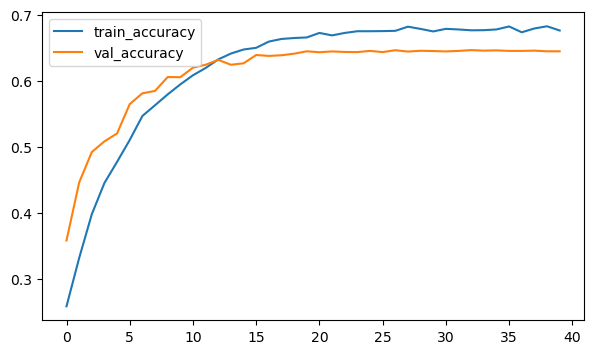

In [222]:
#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

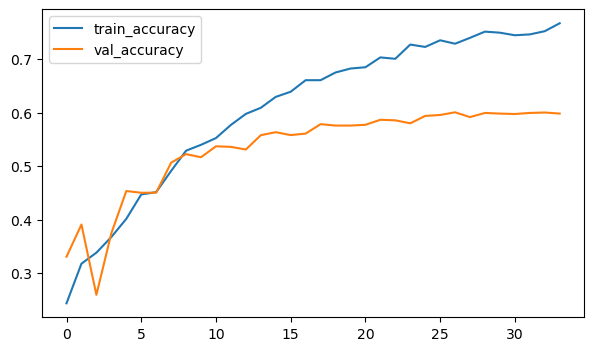

In [129]:
#model3
#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

# Data Augmentation: Powerful Cutout Classification Method

In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import numpy as np
import random
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras import regularizers

import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.regularizers import l2

In [99]:
#help(tf.keras.optimizers.schedules)

Help on package keras.api._v2.keras.optimizers.schedules in keras.api._v2.keras.optimizers:

NAME
    keras.api._v2.keras.optimizers.schedules - AUTOGENERATED. DO NOT EDIT.

PACKAGE CONTENTS


FILE
    d:\anaconda\anaconda download\lib\site-packages\keras\api\_v2\keras\optimizers\schedules\__init__.py




In [275]:
filters = 32
kernel_size = 3
dropout = 0.5
l2_lambda = 1e-4
initial_learning_rate = 0.005
# Define the input shape
input_shape = (32, 32, 3)

# Define the model
inputs = Input(shape=input_shape)
x = Conv2D(filters=filters,kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(inputs)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*2, kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)

x = Conv2D(filters=filters*3,kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=filters*4, kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)

x = Conv2D(filters=filters*5,kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
#x = MaxPooling2D()(x)
x = Conv2D(filters=filters*6, kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)



x = Conv2D(filters=filters*7, kernel_size=kernel_size, activation='elu', padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_lambda))(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(dropout)(x)



outputs = Dense(10, activation='softmax')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=150, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
early_stoppping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=12,verbose=1, restore_best_weights=True)
# Compile the model
model5.compile(optimizer=optimizer ,loss='categorical_crossentropy', metrics=['accuracy'])

In [276]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    IMG_SIZE =32 # cahnge here if you need to
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    IMG_SIZE = image1.shape[0]
    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [277]:
batch_size = 16
auto = tf.data.AUTOTUNE

def make_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    dataset = dataset.shuffle(40000)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(auto)

def _augment_fn(images, labels):
    images = tf.image.random_crop(images, (32, 32, 3))
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_brightness(images, 0.9)
    return images, labels


def make_augmented_datasets(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(5000).map( _augment_fn, num_parallel_calls=auto)

    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(batch_size)


    return dataset.prefetch(auto)

def cut_mix_data(X_traina, y_traina, batch_size ):

    train_ds_one =  tf.data.Dataset.from_tensor_slices((X_traina, y_traina)).shuffle(5000)

    train_ds_two = tf.data.Dataset.from_tensor_slices((X_traina, y_traina)).shuffle(5000)

    train_ds_two = train_ds_two.shuffle(1024).map( _augment_fn, num_parallel_calls=auto)

    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    train_dataset= (train_ds.shuffle(1024).map(cutmix,num_parallel_calls=auto).batch(batch_size ).prefetch(auto))

    return train_dataset



train_set =   cut_mix_data(new_x_train_nor_1, new_y_train_hot_1, batch_size)
val_set =   make_datasets(x_val_nor, y_val_hot)
test_set =  make_datasets(x_test_nor, y_test_hot )

In [ ]:
history = model5.fit(train_set, epochs=100, validation_data=val_set,callbacks=[early_stoppping])
#history = model.fit(train_set, epochs=100, validation_data=val_set)
# Evaluate the model on the test set
test_loss, test_accuracy = model5.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/100
2500/2500 [==============================] - 279s 99ms/step - loss: 2.2300 - accuracy: 0.2806 - val_loss: 1.5698 - val_accuracy: 0.4784
Epoch 2/100
2500/2500 [==============================] - 247s 99ms/step - loss: 1.8523 - accuracy: 0.4274 - val_loss: 1.2142 - val_accuracy: 0.6246
Epoch 3/100
2500/2500 [==============================] - 235s 94ms/step - loss: 1.7247 - accuracy: 0.4875 - val_loss: 1.1207 - val_accuracy: 0.6580
Epoch 4/100
2500/2500 [==============================] - 241s 96ms/step - loss: 1.7001 - accuracy: 0.4982 - val_loss: 1.1057 - val_accuracy: 0.6602
Epoch 5/100
2500/2500 [==============================] - 246s 98ms/step - loss: 1.6929 - accuracy: 0.5068 - val_loss: 1.1017 - val_accuracy: 0.6592
Epoch 6/100
2500/2500 [==============================] - 244s 98ms/step - loss: 1.6961 - accuracy: 0.5033 - val_loss: 1.1008 - val_accuracy: 0.6610
Epoch 7/100
2500/2500 [==============================] - 244s 98ms/step - loss: 1.6935 - accuracy: 0.5055 - val_

In [252]:
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.6827


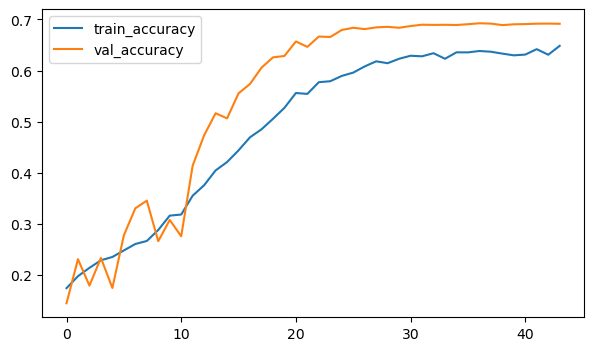

In [253]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

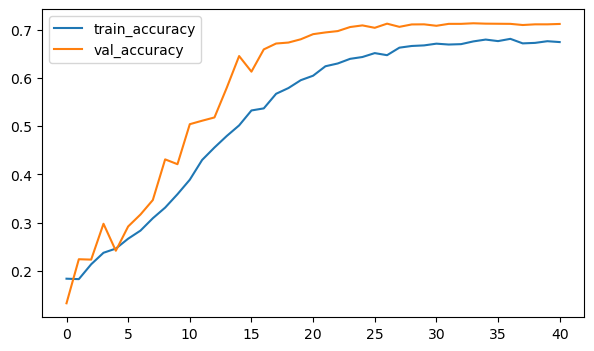

In [241]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

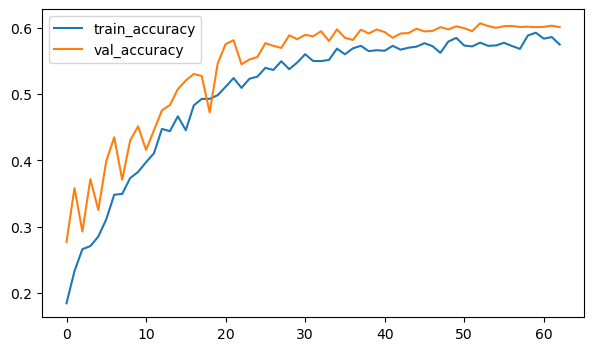

In [38]:
#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

#### after changing filter size

In [55]:
print(f'Test accuracy: {test_accuracy:.4f}')

Test accuracy: 0.6481


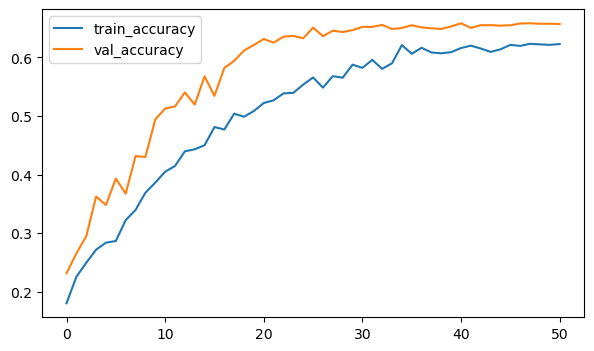

In [51]:


#history = model.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')

Test accuracy: 0.6481


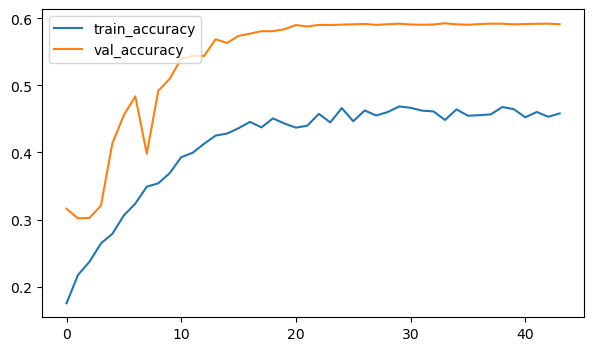

In [64]:
# after changing batch size
print(f'Test accuracy: {test_accuracy:.4f}')
#history = model7.fit(train_set,validation_data=val_set,epochs=20,)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')